In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Flowers102(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 102/102 [00:02<00:00, 50.23it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/flower_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
    'globe flower': 'globe-flower',
    'pink and yellow dahlia': 'pink-yellow dahlia',
    'air plant': 'ball moss',
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name)
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 102/102 [00:00<00:00, 174.89it/s]


In [16]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    original_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in original_gpt3_text_features_cuda]
    original_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in original_gpt3_text_similarity]
    threshold = np.cos(np.deg2rad(45))
    filtered_gpt3_prompts = {label_id: [text for similarity, text in zip(original_gpt3_text_similarity_mean[label_id], original_gpt3_prompts[cls_name]) if similarity >= threshold] for label_id, cls_name in enumerate(cls_names_sorted)}
    filtered_gpt3_prompts = {label_id: list(dict.fromkeys(texts)) for label_id, texts in filtered_gpt3_prompts.items()}
    outliers = {label_id: [text for similarity, text in zip(original_gpt3_text_similarity_mean[label_id], original_gpt3_prompts[cls_name]) if similarity < threshold] for label_id, cls_name in enumerate(cls_names_sorted)}
    for label_id, texts in outliers.items():
        if len(texts) != 0:
            print(f'Filtered {len(texts)} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()

Filtered 1 outliers for (0)pink primrose
["I'm not sure what you are asking."]

Filtered 1 outliers for (2)canterbury bells
['The Canternbury Bells flower is a tall, slender bell with six petals.']

Filtered 1 outliers for (4)english marigold
['Look for a plant with showy, fragrant yellow, orange, or red flowers.']

Filtered 1 outliers for (5)tiger lily
['.']

Filtered 2 outliers for (8)monkshood
['Monkshoods are identified by their striking blue or purple flowers, which are shaped like hoods.', 'Monkshoods are a type of flower that can be identified by their unique hood-like shape.']

Filtered 2 outliers for (9)globe thistle
['.', 'Upright, with spiky, globe-shaped, blue to purple flowers.']

Filtered 3 outliers for (11)colt's foot
["The flowers of a colt's foot (Tussilago farfara) are small, yellow, and clustered.", "A Colt's foot flower (Tussilago farfara) is a small, yellow flower that resembles a dandelion.", "A colt's foot flower (Also known as Tussilago farfara) is a small yello

In [17]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 102/102 [00:00<00:00, 194.36it/s]


In [18]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [19]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 102/102 [00:23<00:00,  4.31it/s]


In [20]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [21]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [22]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [23]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 64.80%
Accuracy of CLIP with text template (centroid): 65.90%
Accuracy of CLIP with text template (individual avg): 65.41%
Accuracy of CLIP with original GPT-3 text (centroid): 73.81%
Accuracy of CLIP with original GPT-3 text (individual avg): 73.37%
Accuracy of CLIP with filtered GPT-3 text (centroid): 73.97%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 73.16%
Accuracy of CLIP with combined original GPT-3 text (centroid): 68.86%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 68.33%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 68.57%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 68.21%


In [24]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [25]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=64.45%, std=0.041590318903450836
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=66.85%, std=0.02635413955517039


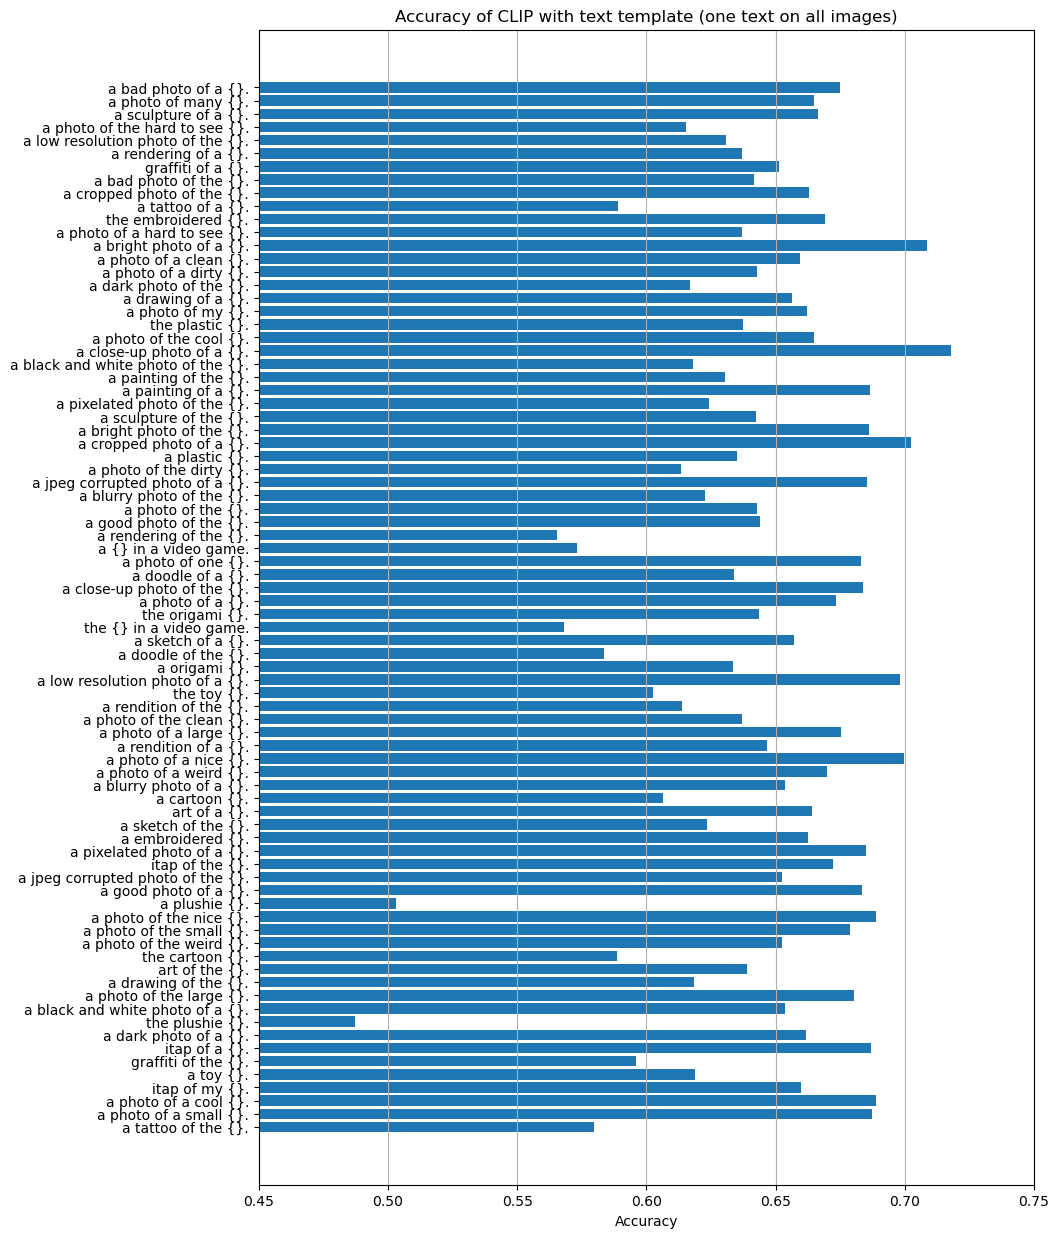

In [26]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [27]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [28]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [29]:
def print_top_pairs(similarity, text, top=10):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [30]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [31]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [32]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [33]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20)
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20)
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.56787109375
Class name similarity std: 0.0955810546875
Rank 1: (50)petunia - (97)mexican petunia, similarity: 0.88720703125
Rank 2: (4)english marigold - (46)marigold, similarity: 0.8837890625
Rank 3: (25)corn poppy - (69)tree poppy, similarity: 0.8828125
Rank 4: (85)tree mallow - (96)mallow, similarity: 0.8818359375
Rank 5: (5)tiger lily - (20)fire lily, similarity: 0.84521484375
Rank 6: (20)fire lily - (42)sword lily, similarity: 0.84375
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.8408203125
Rank 8: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.83447265625
Rank 9: (3)sweet pea - (47)buttercup, similarity: 0.83447265625
Rank 10: (3)sweet pea - (73)rose, similarity: 0.8251953125


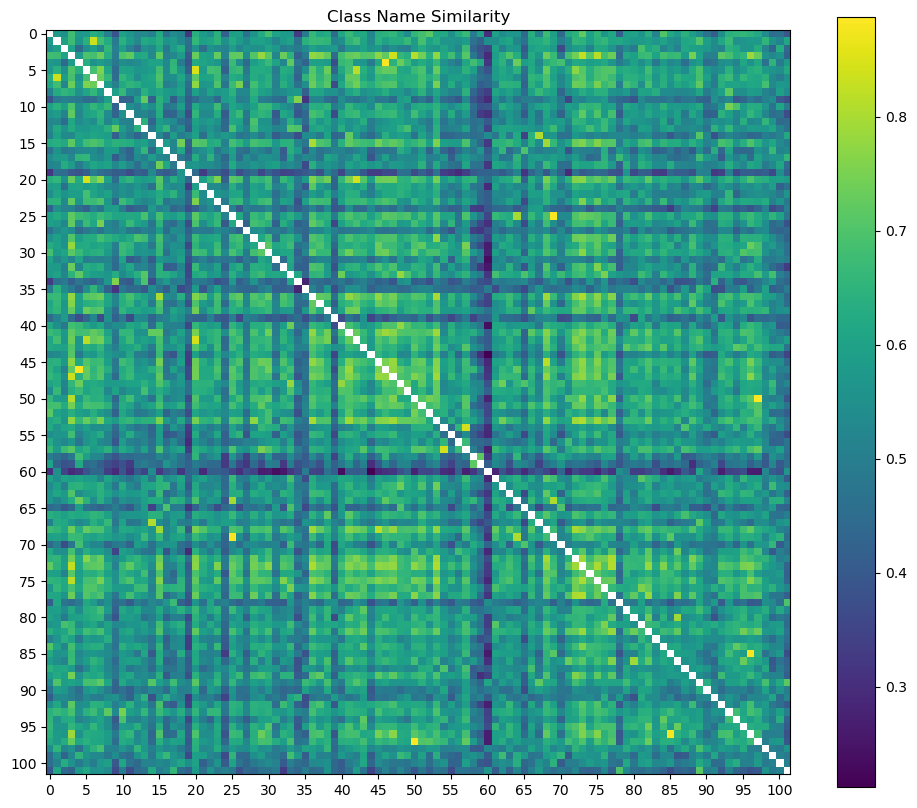

Text template similarity mean: 0.5830078125
Text template similarity std: 0.0941162109375
Rank 1: (4)english marigold - (46)marigold, similarity: 0.95703125
Rank 2: (50)petunia - (97)mexican petunia, similarity: 0.94384765625
Rank 3: (85)tree mallow - (96)mallow, similarity: 0.890625
Rank 4: (25)corn poppy - (69)tree poppy, similarity: 0.8818359375
Rank 5: (20)fire lily - (42)sword lily, similarity: 0.87841796875
Rank 6: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.86865234375
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.86376953125
Rank 8: (5)tiger lily - (20)fire lily, similarity: 0.85107421875
Rank 9: (36)cape flower - (73)rose, similarity: 0.8486328125
Rank 10: (72)water lily - (77)lotus, similarity: 0.8447265625


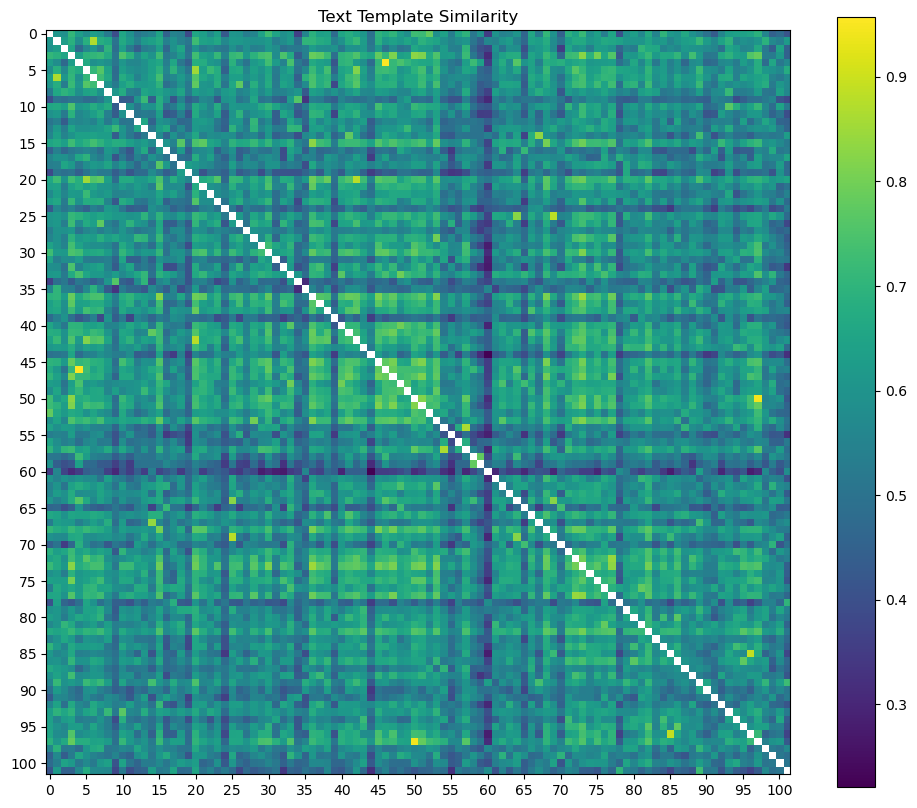

Original gpt-3 text similarity mean: 0.603515625
Original gpt-3 text similarity std: 0.086669921875
Rank 1: (4)english marigold - (46)marigold, similarity: 0.978515625
Rank 2: (50)petunia - (97)mexican petunia, similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, similarity: 0.94677734375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, similarity: 0.8984375
Rank 6: (25)corn poppy - (69)tree poppy, similarity: 0.8955078125
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.89501953125
Rank 8: (14)yellow iris - (67)bearded iris, similarity: 0.88916015625
Rank 9: (5)tiger lily - (20)fire lily, similarity: 0.888671875
Rank 10: (20)fire lily - (42)sword lily, similarity: 0.8818359375


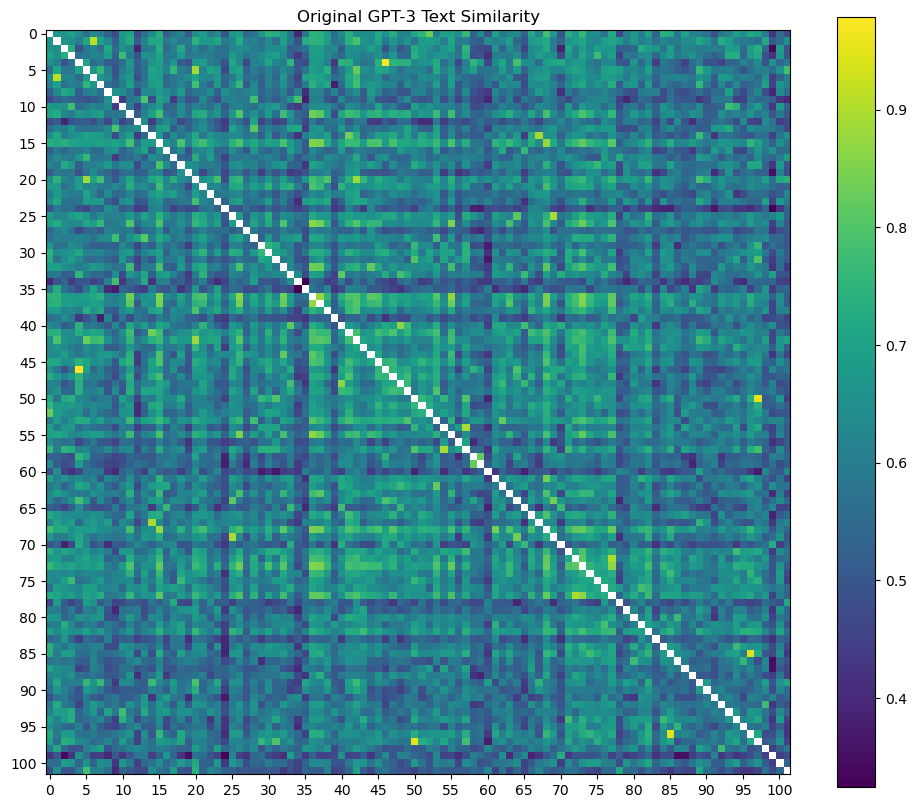

Filtered gpt-3 text similarity mean: 0.5927734375
Filtered gpt-3 text similarity std: 0.09112548828125
Rank 1: (4)english marigold - (46)marigold, similarity: 0.9775390625
Rank 2: (50)petunia - (97)mexican petunia, similarity: 0.95849609375
Rank 3: (85)tree mallow - (96)mallow, similarity: 0.9443359375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, similarity: 0.8955078125
Rank 6: (25)corn poppy - (69)tree poppy, similarity: 0.8935546875
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.89013671875
Rank 8: (14)yellow iris - (67)bearded iris, similarity: 0.88916015625
Rank 9: (5)tiger lily - (20)fire lily, similarity: 0.8818359375
Rank 10: (20)fire lily - (42)sword lily, similarity: 0.88037109375


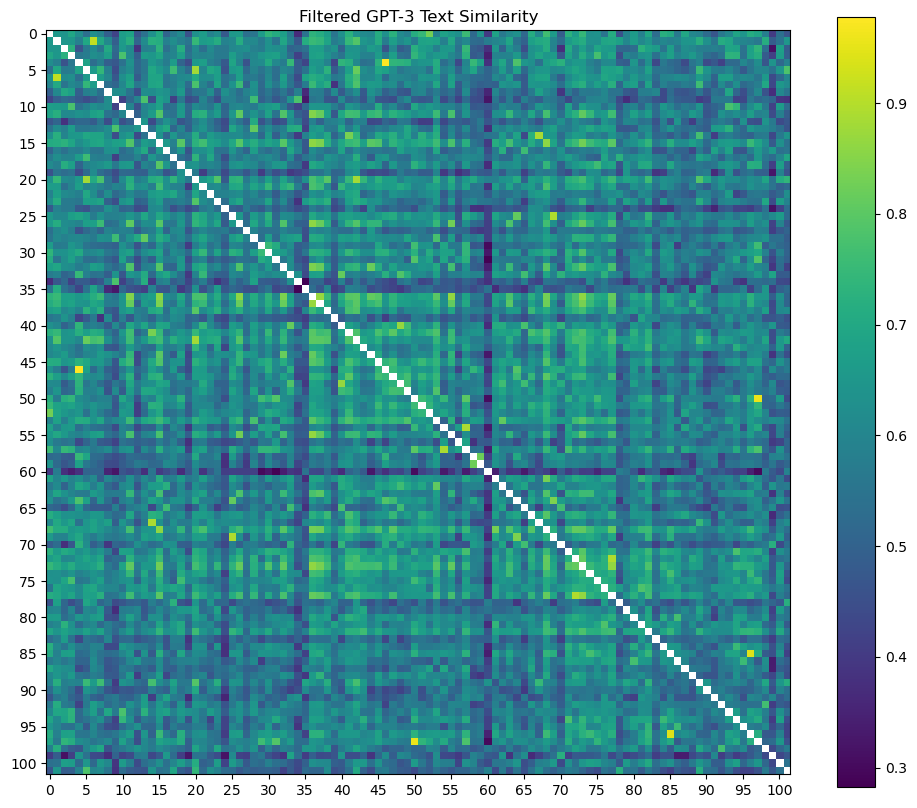

In [34]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.85791015625
Image similarity std: 0.04010009765625
Rank 1: (72)water lily - (77)lotus, similarity: 0.97998046875
Rank 2: (11)colt's foot - (49)common dandelion, similarity: 0.97265625
Rank 3: (4)english marigold - (40)barbeton daisy, similarity: 0.9716796875
Rank 4: (40)barbeton daisy - (70)gazania, similarity: 0.9697265625
Rank 5: (4)english marigold - (70)gazania, similarity: 0.96923828125
Rank 6: (70)gazania - (99)blanket flower, similarity: 0.9677734375
Rank 7: (42)sword lily - (89)canna lily, similarity: 0.966796875
Rank 8: (4)english marigold - (99)blanket flower, similarity: 0.96240234375
Rank 9: (40)barbeton daisy - (65)osteospermum, similarity: 0.9609375
Rank 10: (3)sweet pea - (10)snapdragon, similarity: 0.9599609375


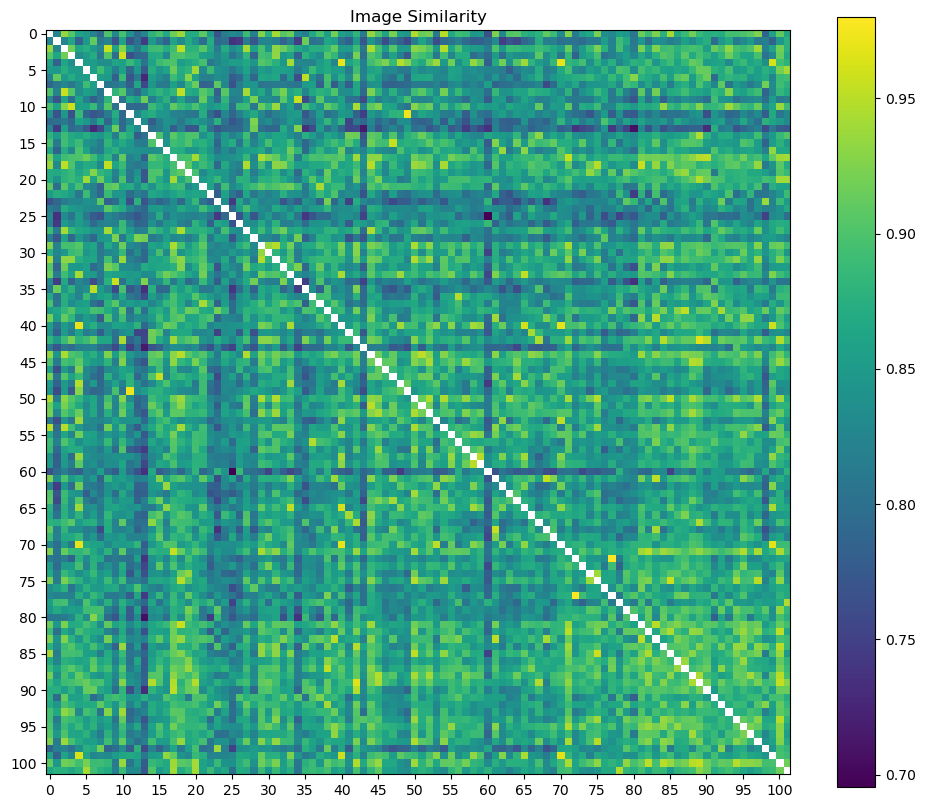

Image to class name similarity mean: 0.21630859375
Image to class name similarity std: 0.0355224609375
Image to class name similarity diagonal mean: 0.30810546875
Image to class name similarity diagonal std: 0.034454345703125
Image to class name similarity non-diagonal mean: 0.21533203125
Image to class name similarity non-diagonal std: 0.034332275390625
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.4306640625
Rank 1: (46)marigold - (4)english marigold, similarity: 0.34521484375
Rank 2: (11)colt's foot - (49)common dandelion, similarity: 0.326904296875
Rank 3: (68)windflower - (61)japanese anemone, similarity: 0.3232421875
Rank 4: (57)geranium - (54)pelargonium, similarity: 0.3203125
Rank 5: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.317626953125
Rank 6: (23)red ginger - (98)bromelia, similarity: 0.31298828125
Rank 7: (99)blanket flower - (70)gazania, similarity: 0.312255859375
Rank 8: (5)tiger lily - (20)fire lily, similarity: 0.311279296

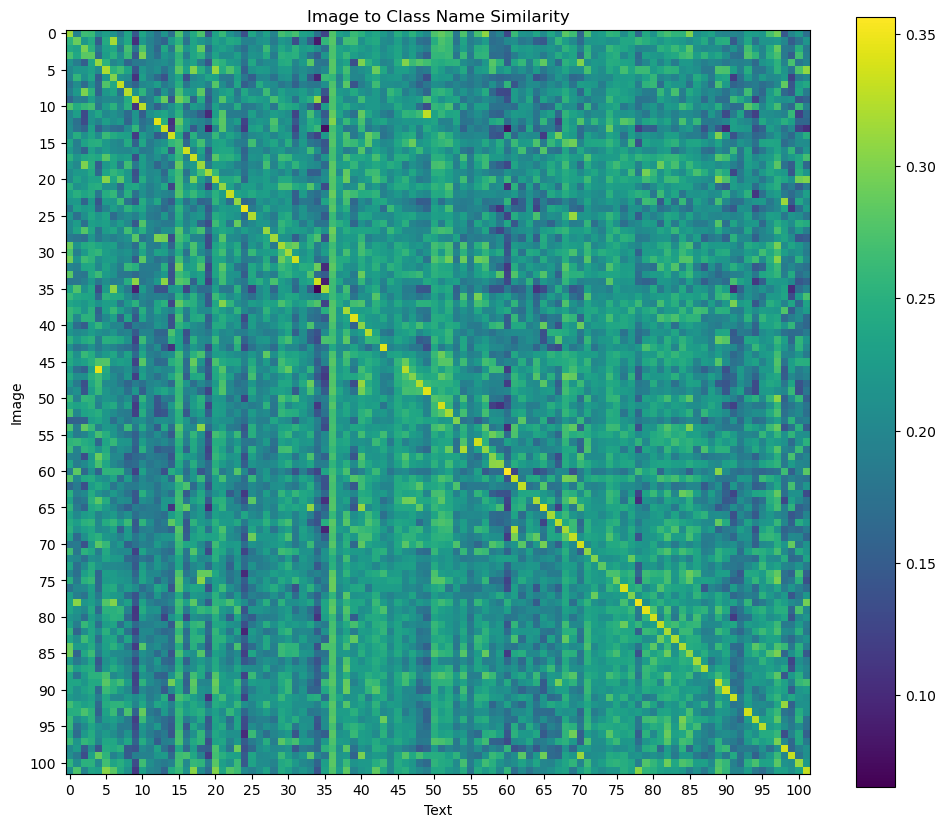

Rank 1: (46)marigold - (4)english marigold, error rate: 1.0
Rank 2: (1)hard-leaved pocket orchid - (6)moon orchid, error rate: 1.0
Rank 3: (57)geranium - (54)pelargonium, error rate: 1.0
Rank 4: (11)colt's foot - (49)common dandelion, error rate: 0.9615384615384616
Rank 5: (92)ball moss - (98)bromelia, error rate: 0.8571428571428571
Rank 6: (36)cape flower - (56)gaura, error rate: 0.84375
Rank 7: (50)petunia - (97)mexican petunia, error rate: 0.7922077922077922
Rank 8: (55)bishop of llandaff - (58)orange dahlia, error rate: 0.7272727272727273
Rank 9: (68)windflower - (61)japanese anemone, error rate: 0.6875
Rank 10: (54)pelargonium - (18)balloon flower, error rate: 0.6190476190476191
Rank 11: (23)red ginger - (98)bromelia, error rate: 0.6153846153846154
Rank 12: (75)morning glory - (18)balloon flower, error rate: 0.59375
Rank 13: (26)prince of wales feathers - (23)red ginger, error rate: 0.5
Rank 14: (63)silverbush - (84)desert-rose, error rate: 0.5
Rank 15: (32)love in the mist - (15)

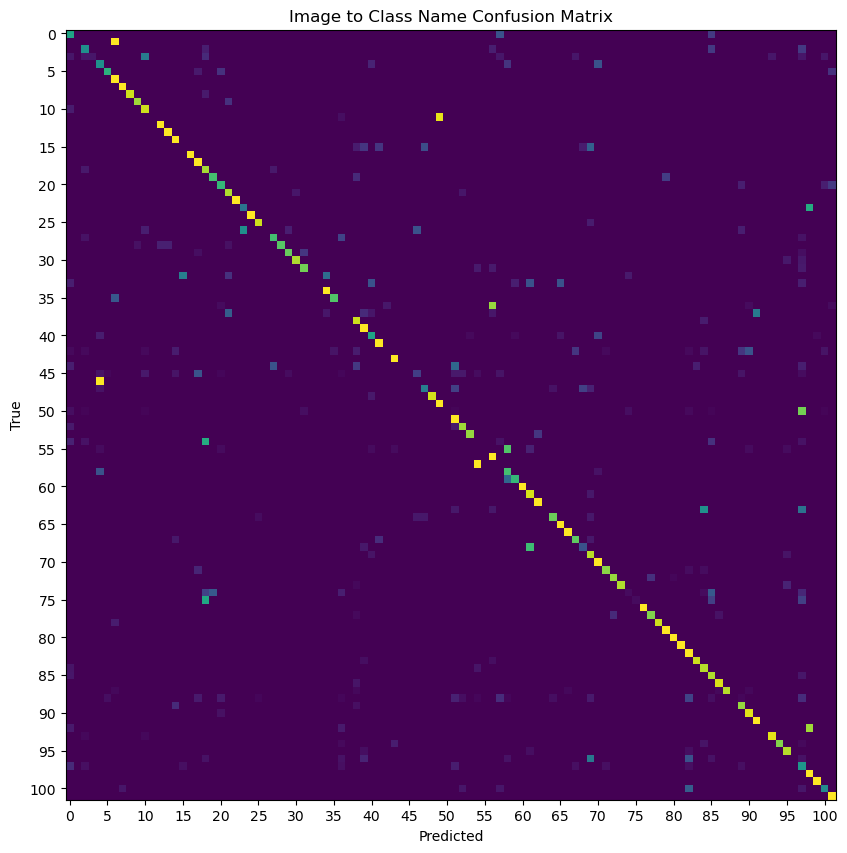

Image to text template (centroid) similarity mean: 0.230224609375
Image to text template (centroid) similarity std: 0.037841796875
Image to text template (centroid) similarity diagonal mean: 0.32861328125
Image to text template (centroid) similarity diagonal std: 0.038330078125
Image to text template (centroid) similarity non-diagonal mean: 0.229248046875
Image to text template (centroid) similarity non-diagonal std: 0.036529541015625
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.43359375
Rank 1: (46)marigold - (4)english marigold, similarity: 0.370849609375
Rank 2: (68)windflower - (61)japanese anemone, similarity: 0.34521484375
Rank 3: (5)tiger lily - (20)fire lily, similarity: 0.343017578125
Rank 4: (11)colt's foot - (49)common dandelion, similarity: 0.3427734375
Rank 5: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.337890625
Rank 6: (57)geranium - (54)pelargonium, similarity: 0.33642578125
Rank 7: (48)oxeye daisy - (40)barbe

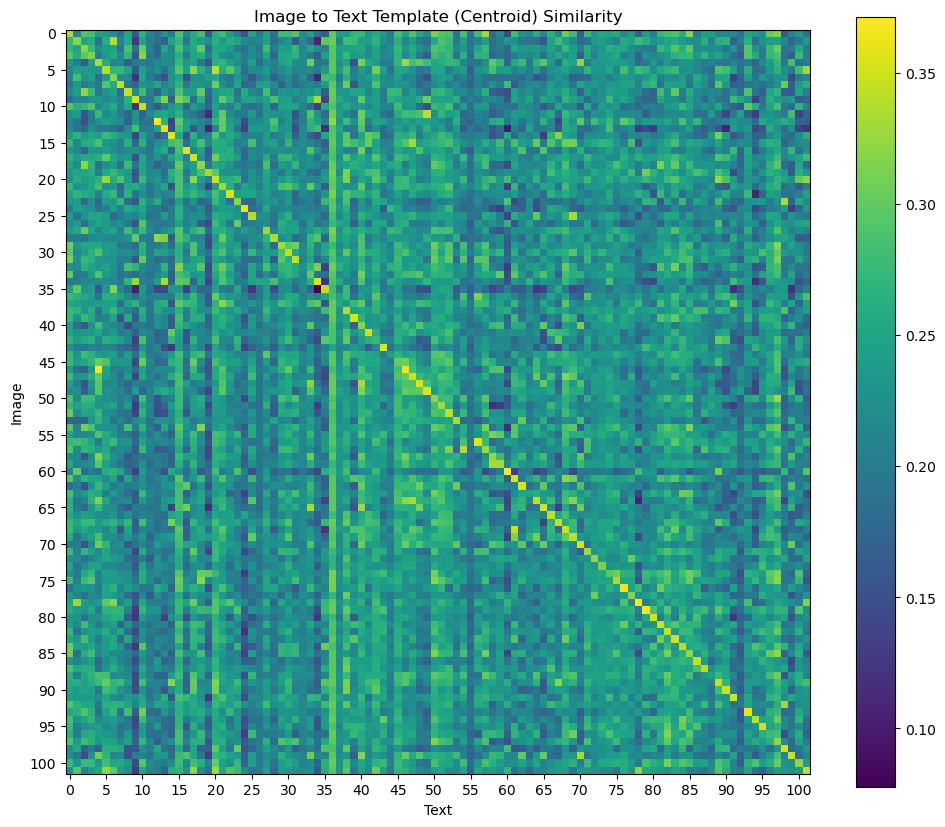

Rank 1: (46)marigold - (4)english marigold, error rate: 1.0
Rank 2: (11)colt's foot - (49)common dandelion, error rate: 0.9615384615384616
Rank 3: (1)hard-leaved pocket orchid - (6)moon orchid, error rate: 0.9444444444444444
Rank 4: (92)ball moss - (98)bromelia, error rate: 0.8571428571428571
Rank 5: (57)geranium - (54)pelargonium, error rate: 0.8529411764705882
Rank 6: (15)globe-flower - (47)buttercup, error rate: 0.8461538461538461
Rank 7: (36)cape flower - (56)gaura, error rate: 0.78125
Rank 8: (55)bishop of llandaff - (58)orange dahlia, error rate: 0.7575757575757576
Rank 9: (50)petunia - (97)mexican petunia, error rate: 0.7012987012987013
Rank 10: (23)red ginger - (98)bromelia, error rate: 0.6923076923076923
Rank 11: (26)prince of wales feathers - (23)red ginger, error rate: 0.5833333333333334
Rank 12: (5)tiger lily - (20)fire lily, error rate: 0.5
Rank 13: (37)great masterwort - (21)pincushion flower, error rate: 0.47058823529411764
Rank 14: (96)mallow - (82)hibiscus, error rate:

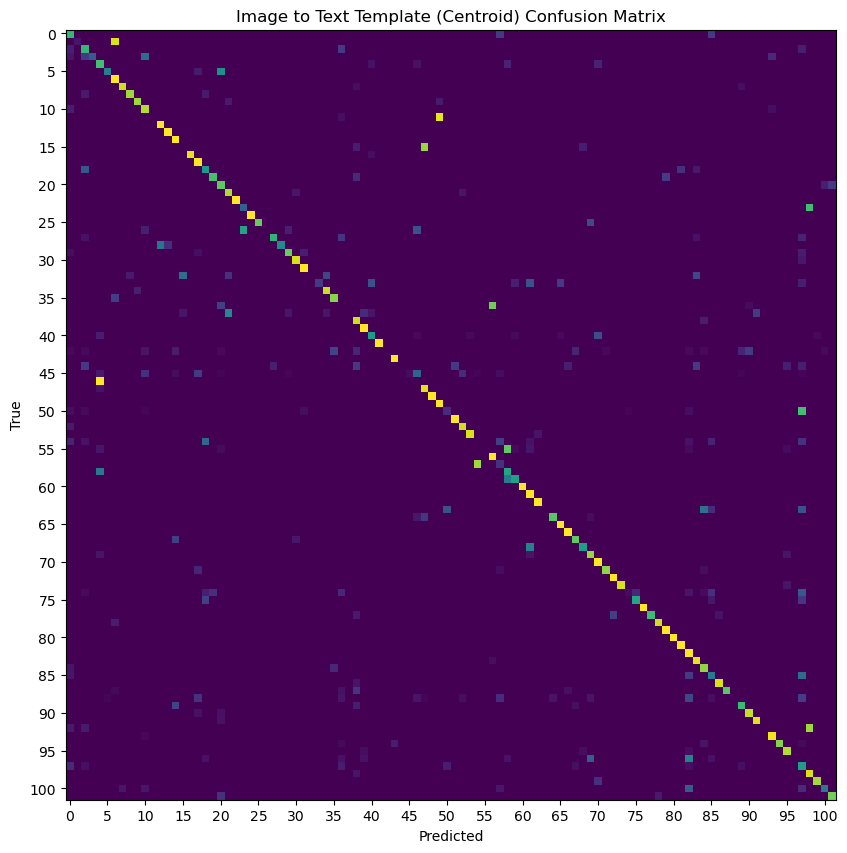

Image to text template (individual avg) similarity mean: 0.210280641913414
Image to text template (individual avg) similarity std: 0.034066684544086456
Image to text template (individual avg) similarity diagonal mean: 0.30036118626594543
Image to text template (individual avg) similarity diagonal std: 0.03521967679262161
Image to text template (individual avg) similarity non-diagonal mean: 0.20938873291015625
Image to text template (individual avg) similarity non-diagonal std: 0.03284221887588501
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.43446683883667
Rank 1: (46)marigold - (4)english marigold, similarity: 0.33203125
Rank 2: (68)windflower - (61)japanese anemone, similarity: 0.31787109375
Rank 3: (5)tiger lily - (20)fire lily, similarity: 0.313232421875
Rank 4: (11)colt's foot - (49)common dandelion, similarity: 0.3115234375
Rank 5: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.311279296875
Rank 6: (57)geranium - (54)

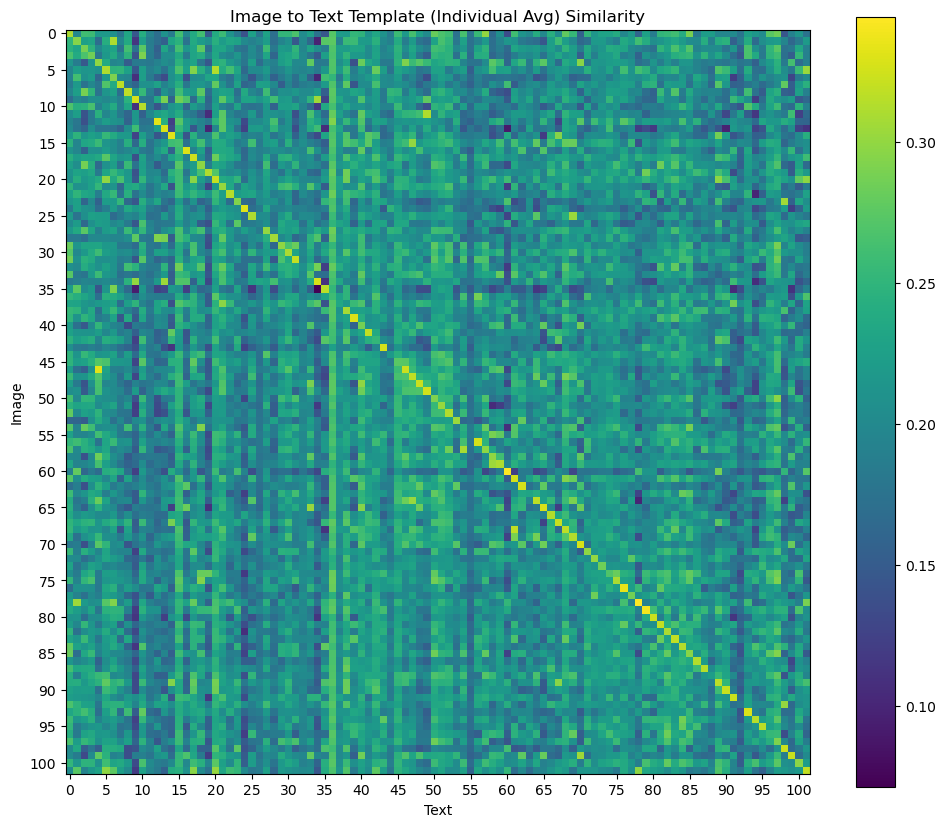

Rank 1: (46)marigold - (4)english marigold, error rate: 1.0
Rank 2: (57)geranium - (54)pelargonium, error rate: 1.0
Rank 3: (11)colt's foot - (49)common dandelion, error rate: 0.9615384615384616
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, error rate: 0.9444444444444444
Rank 5: (92)ball moss - (98)bromelia, error rate: 0.8571428571428571
Rank 6: (55)bishop of llandaff - (58)orange dahlia, error rate: 0.7878787878787878
Rank 7: (50)petunia - (97)mexican petunia, error rate: 0.7792207792207793
Rank 8: (15)globe-flower - (47)buttercup, error rate: 0.7692307692307693
Rank 9: (23)red ginger - (98)bromelia, error rate: 0.6923076923076923
Rank 10: (36)cape flower - (56)gaura, error rate: 0.6875
Rank 11: (37)great masterwort - (21)pincushion flower, error rate: 0.5882352941176471
Rank 12: (26)prince of wales feathers - (23)red ginger, error rate: 0.5833333333333334
Rank 13: (68)windflower - (61)japanese anemone, error rate: 0.5
Rank 14: (77)lotus - (72)water lily, error rate: 0.47619

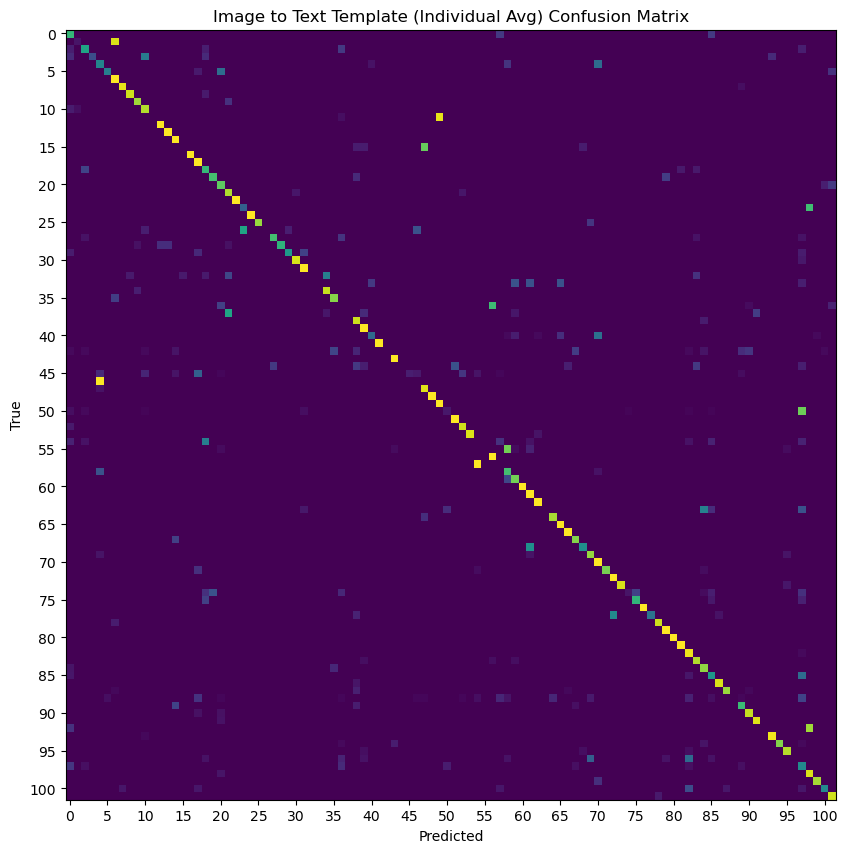

Image to original gpt-3 text (centroid) similarity mean: 0.2371826171875
Image to original gpt-3 text (centroid) similarity std: 0.040679931640625
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.34765625
Image to original gpt-3 text (centroid) similarity diagonal std: 0.02447509765625
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.236083984375
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.039276123046875
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.47265625
Rank 1: (68)windflower - (61)japanese anemone, similarity: 0.365234375
Rank 2: (5)tiger lily - (20)fire lily, similarity: 0.36376953125
Rank 3: (46)marigold - (4)english marigold, similarity: 0.363525390625
Rank 4: (101)blackberry lily - (5)tiger lily, similarity: 0.356201171875
Rank 5: (34)alpine sea holly - (9)globe thistle, similarity: 0.35595703125
Rank 6: (48)oxeye daisy - (40)barbeton daisy, similarity: 0.355

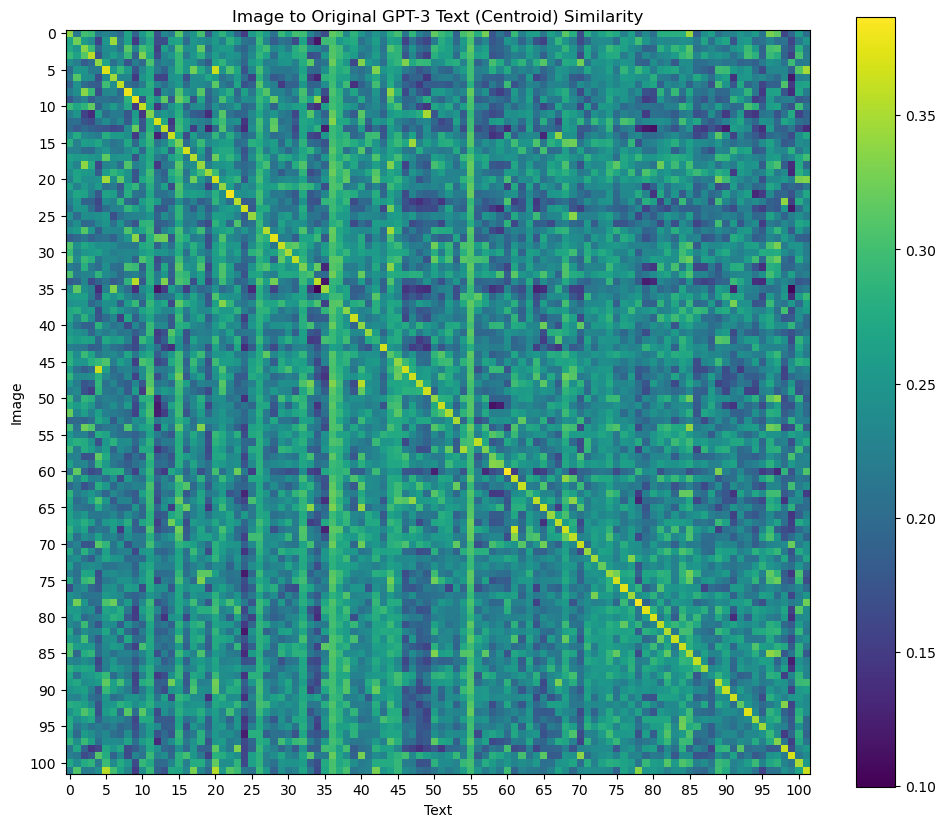

Rank 1: (57)geranium - (54)pelargonium, error rate: 1.0
Rank 2: (1)hard-leaved pocket orchid - (6)moon orchid, error rate: 1.0
Rank 3: (11)colt's foot - (49)common dandelion, error rate: 0.8846153846153846
Rank 4: (92)ball moss - (98)bromelia, error rate: 0.7857142857142857
Rank 5: (15)globe-flower - (47)buttercup, error rate: 0.7692307692307693
Rank 6: (59)pink-yellow dahlia - (58)orange dahlia, error rate: 0.696969696969697
Rank 7: (32)love in the mist - (44)bolero deep blue, error rate: 0.6428571428571429
Rank 8: (55)bishop of llandaff - (58)orange dahlia, error rate: 0.6363636363636364
Rank 9: (36)cape flower - (56)gaura, error rate: 0.625
Rank 10: (48)oxeye daisy - (40)barbeton daisy, error rate: 0.6
Rank 11: (54)pelargonium - (85)tree mallow, error rate: 0.5714285714285714
Rank 12: (68)windflower - (61)japanese anemone, error rate: 0.5
Rank 13: (26)prince of wales feathers - (23)red ginger, error rate: 0.5
Rank 14: (34)alpine sea holly - (9)globe thistle, error rate: 0.5
Rank 15:

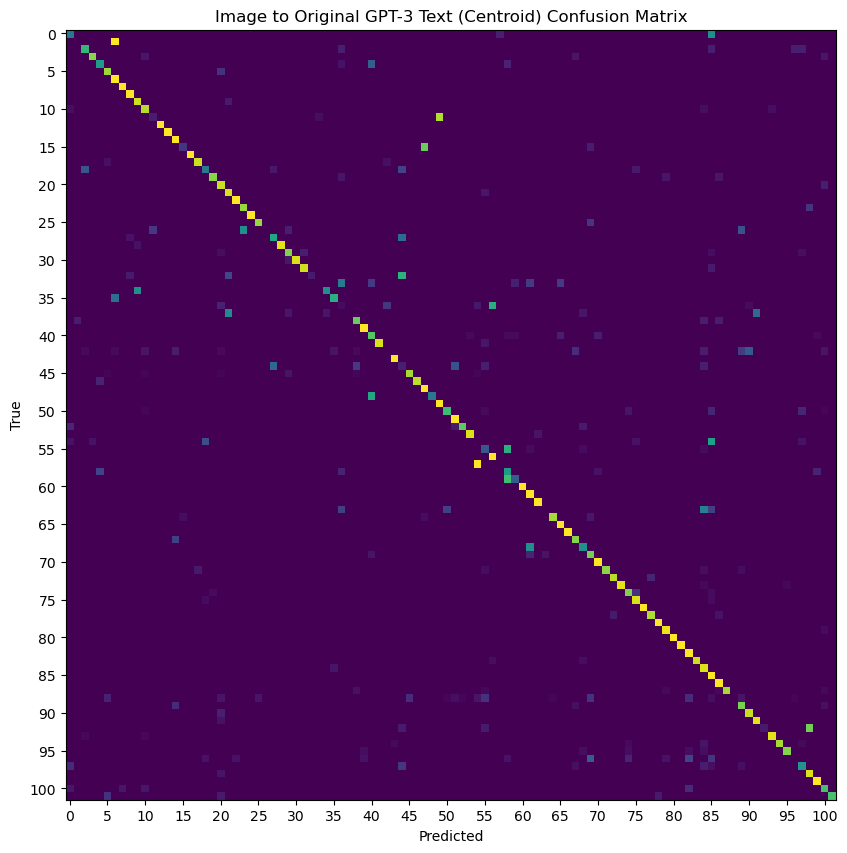

Image to original gpt-3 text (individual avg) similarity mean: 0.224113330245018
Image to original gpt-3 text (individual avg) similarity std: 0.03712676092982292
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.329164981842041
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.025561468675732613
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.22307319939136505
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.03571031987667084
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.475591778755188
Rank 1: (46)marigold - (4)english marigold, similarity: 0.3466796875
Rank 2: (5)tiger lily - (20)fire lily, similarity: 0.341796875
Rank 3: (68)windflower - (61)japanese anemone, similarity: 0.338134765625
Rank 4: (5)tiger lily - (101)blackberry lily, similarity: 0.33349609375
Rank 5: (101)blackberry lily - (20)fire lily, similarity: 0.333251953

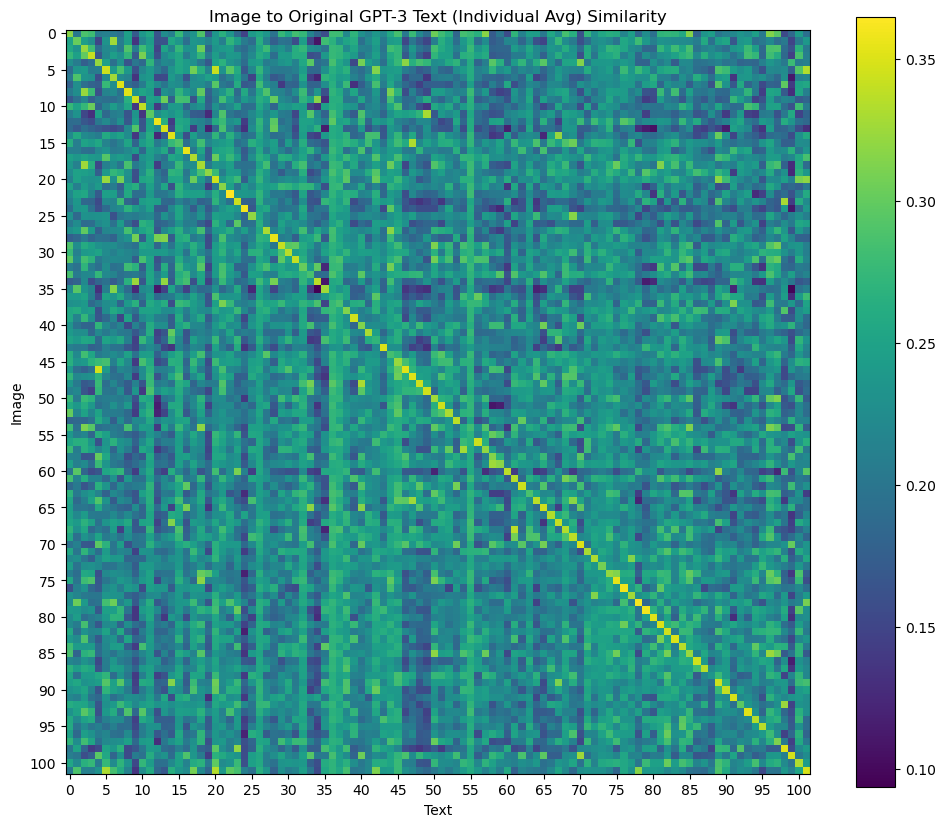

Rank 1: (15)globe-flower - (47)buttercup, error rate: 1.0
Rank 2: (1)hard-leaved pocket orchid - (6)moon orchid, error rate: 1.0
Rank 3: (11)colt's foot - (49)common dandelion, error rate: 0.9230769230769231
Rank 4: (57)geranium - (54)pelargonium, error rate: 0.9117647058823529
Rank 5: (92)ball moss - (98)bromelia, error rate: 0.8571428571428571
Rank 6: (55)bishop of llandaff - (58)orange dahlia, error rate: 0.8484848484848485
Rank 7: (59)pink-yellow dahlia - (58)orange dahlia, error rate: 0.8181818181818182
Rank 8: (68)windflower - (61)japanese anemone, error rate: 0.625
Rank 9: (36)cape flower - (56)gaura, error rate: 0.625
Rank 10: (54)pelargonium - (18)balloon flower, error rate: 0.5714285714285714
Rank 11: (32)love in the mist - (44)bolero deep blue, error rate: 0.5714285714285714
Rank 12: (37)great masterwort - (91)bee balm, error rate: 0.5294117647058824
Rank 13: (63)silverbush - (50)petunia, error rate: 0.5
Rank 14: (26)prince of wales feathers - (23)red ginger, error rate: 0.5

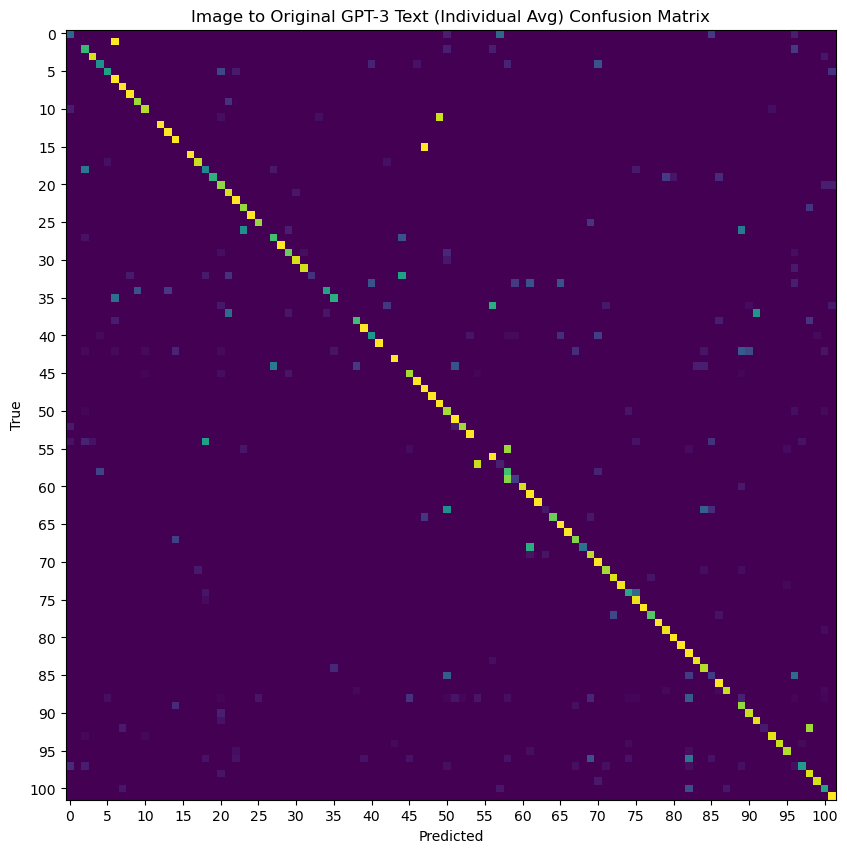

Image to filtered gpt-3 text (centroid) similarity mean: 0.23486328125
Image to filtered gpt-3 text (centroid) similarity std: 0.04150390625
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.345947265625
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.025115966796875
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.2337646484375
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.04010009765625
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.4794921875
Rank 1: (5)tiger lily - (20)fire lily, similarity: 0.36376953125
Rank 2: (68)windflower - (61)japanese anemone, similarity: 0.362060546875
Rank 3: (46)marigold - (4)english marigold, similarity: 0.361083984375
Rank 4: (101)blackberry lily - (5)tiger lily, similarity: 0.355712890625
Rank 5: (48)oxeye daisy - (40)barbeton daisy, similarity: 0.35546875
Rank 6: (101)blackberry lily - (20)fire lily, similarity: 0.35449

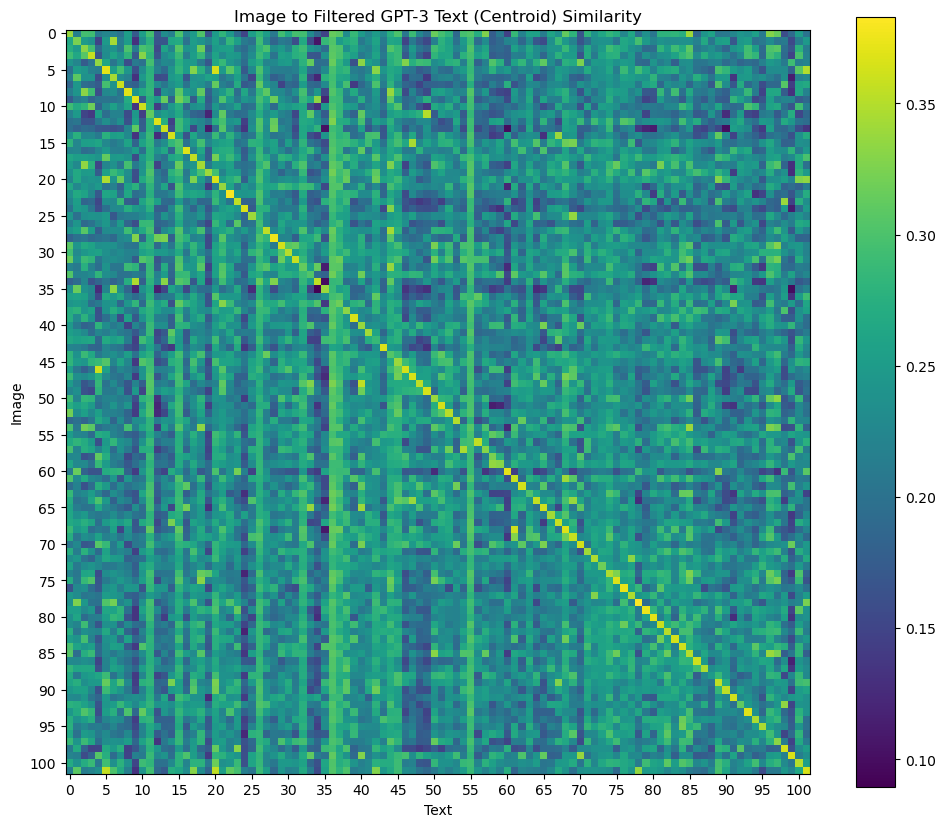

Rank 1: (57)geranium - (54)pelargonium, error rate: 1.0
Rank 2: (1)hard-leaved pocket orchid - (6)moon orchid, error rate: 1.0
Rank 3: (15)globe-flower - (47)buttercup, error rate: 0.9230769230769231
Rank 4: (11)colt's foot - (49)common dandelion, error rate: 0.9230769230769231
Rank 5: (92)ball moss - (98)bromelia, error rate: 0.7857142857142857
Rank 6: (32)love in the mist - (44)bolero deep blue, error rate: 0.7142857142857143
Rank 7: (59)pink-yellow dahlia - (58)orange dahlia, error rate: 0.696969696969697
Rank 8: (55)bishop of llandaff - (58)orange dahlia, error rate: 0.6666666666666666
Rank 9: (48)oxeye daisy - (40)barbeton daisy, error rate: 0.6
Rank 10: (54)pelargonium - (85)tree mallow, error rate: 0.5238095238095238
Rank 11: (26)prince of wales feathers - (23)red ginger, error rate: 0.5
Rank 12: (44)bolero deep blue - (27)stemless gentian, error rate: 0.5
Rank 13: (37)great masterwort - (21)pincushion flower, error rate: 0.47058823529411764
Rank 14: (26)prince of wales feathers

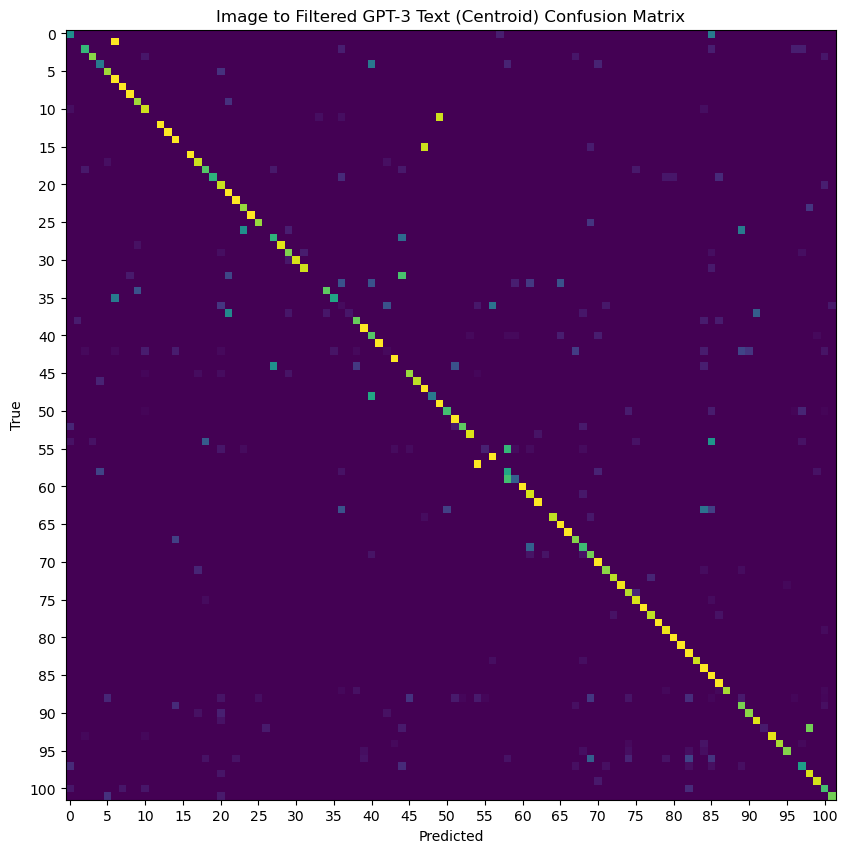

Image to filtered gpt-3 text (individual avg) similarity mean: 0.22408655285835266
Image to filtered gpt-3 text (individual avg) similarity std: 0.038544442504644394
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.3305424749851227
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.02570616453886032
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.22303253412246704
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.0371553972363472
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.48203706741333
Rank 1: (46)marigold - (4)english marigold, similarity: 0.3486328125
Rank 2: (68)windflower - (61)japanese anemone, similarity: 0.3427734375
Rank 3: (5)tiger lily - (20)fire lily, similarity: 0.341796875
Rank 4: (101)blackberry lily - (5)tiger lily, similarity: 0.337158203125
Rank 5: (11)colt's foot - (49)common dandelion, similarity: 0.3359375

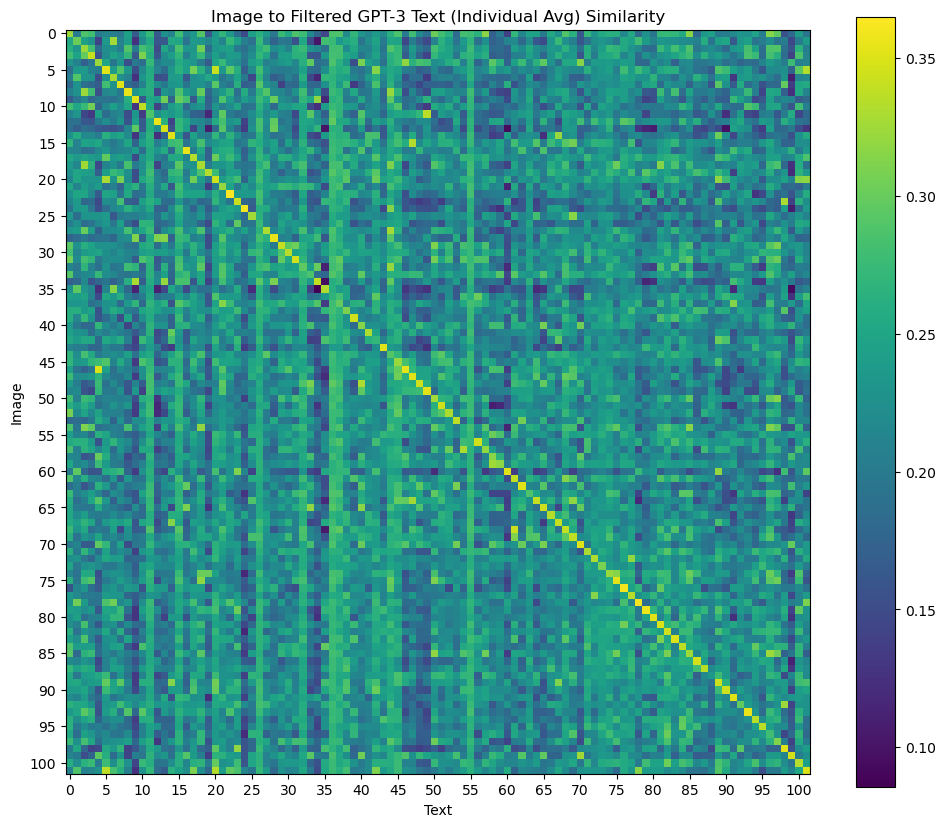

Rank 1: (1)hard-leaved pocket orchid - (6)moon orchid, error rate: 1.0
Rank 2: (15)globe-flower - (47)buttercup, error rate: 1.0
Rank 3: (57)geranium - (54)pelargonium, error rate: 0.9705882352941176
Rank 4: (11)colt's foot - (49)common dandelion, error rate: 0.9615384615384616
Rank 5: (55)bishop of llandaff - (58)orange dahlia, error rate: 0.8484848484848485
Rank 6: (59)pink-yellow dahlia - (58)orange dahlia, error rate: 0.8181818181818182
Rank 7: (92)ball moss - (98)bromelia, error rate: 0.7857142857142857
Rank 8: (32)love in the mist - (44)bolero deep blue, error rate: 0.7142857142857143
Rank 9: (36)cape flower - (56)gaura, error rate: 0.65625
Rank 10: (68)windflower - (61)japanese anemone, error rate: 0.625
Rank 11: (26)prince of wales feathers - (23)red ginger, error rate: 0.5833333333333334
Rank 12: (54)pelargonium - (18)balloon flower, error rate: 0.5714285714285714
Rank 13: (37)great masterwort - (91)bee balm, error rate: 0.5294117647058824
Rank 14: (63)silverbush - (84)desert-

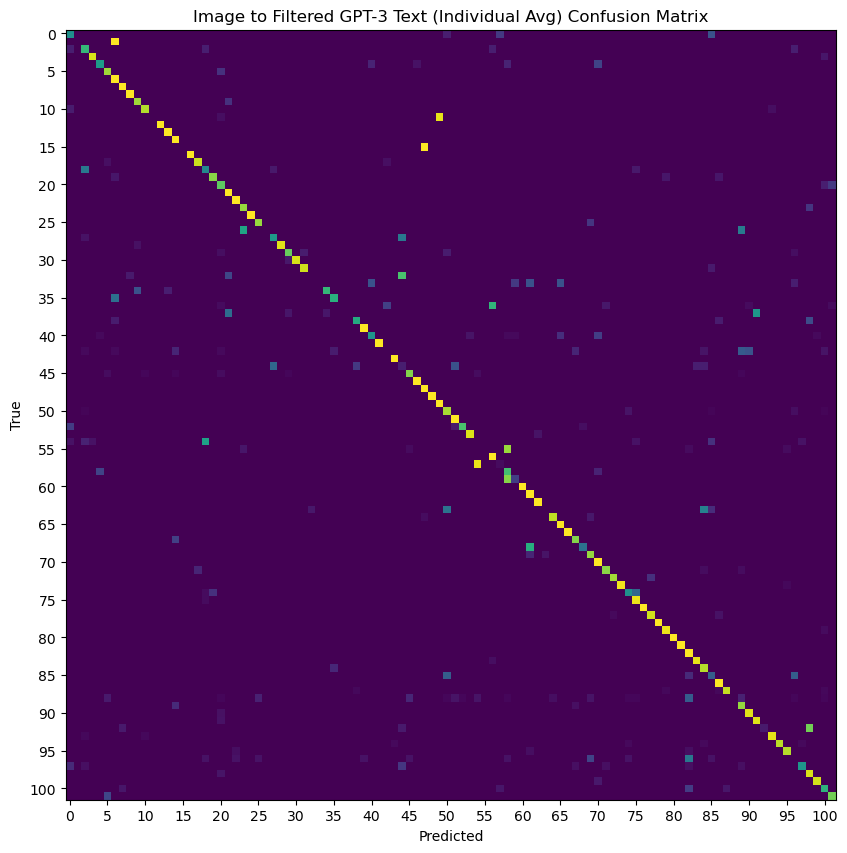

In [35]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [36]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [37]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [38]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (50)petunia - (97)mexican petunia, similarity: 0.88720703125
Rank 2: (4)english marigold - (46)marigold, similarity: 0.8837890625
Rank 3: (25)corn poppy - (69)tree poppy, similarity: 0.8828125
Rank 4: (85)tree mallow - (96)mallow, similarity: 0.8818359375
Rank 5: (5)tiger lily - (20)fire lily, similarity: 0.84521484375
Rank 6: (20)fire lily - (42)sword lily, similarity: 0.84375
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.8408203125
Rank 8: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.83447265625
Rank 9: (3)sweet pea - (47)buttercup, similarity: 0.83447265625
Rank 10: (3)sweet pea - (73)rose, similarity: 0.8251953125


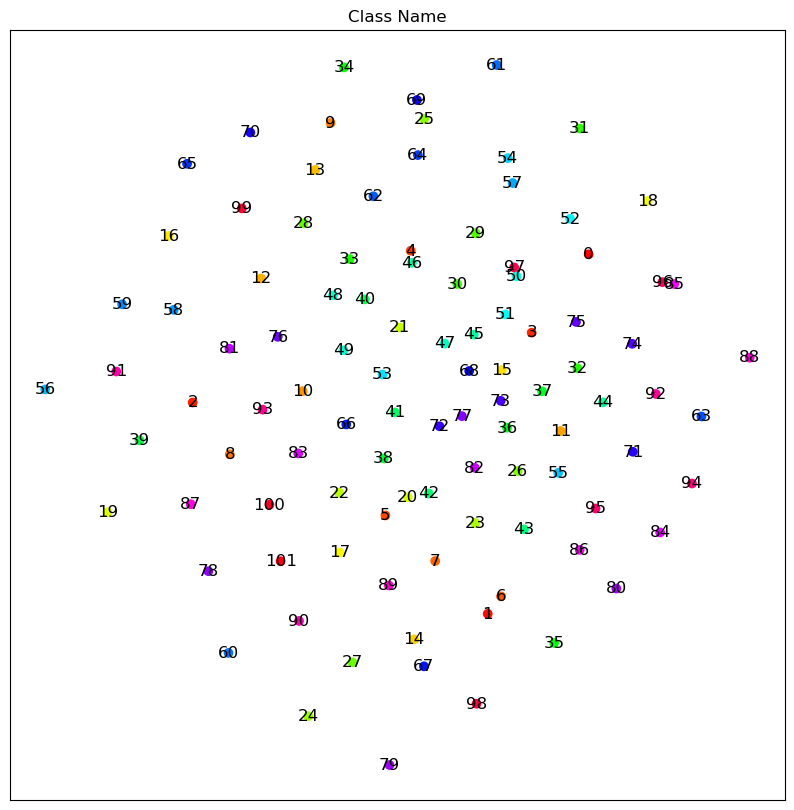

Rank 1: (4)english marigold - (46)marigold, similarity: 0.95703125
Rank 2: (50)petunia - (97)mexican petunia, similarity: 0.94384765625
Rank 3: (85)tree mallow - (96)mallow, similarity: 0.890625
Rank 4: (25)corn poppy - (69)tree poppy, similarity: 0.8818359375
Rank 5: (20)fire lily - (42)sword lily, similarity: 0.87841796875
Rank 6: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.86865234375
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.86376953125
Rank 8: (5)tiger lily - (20)fire lily, similarity: 0.85107421875
Rank 9: (36)cape flower - (73)rose, similarity: 0.8486328125
Rank 10: (72)water lily - (77)lotus, similarity: 0.8447265625


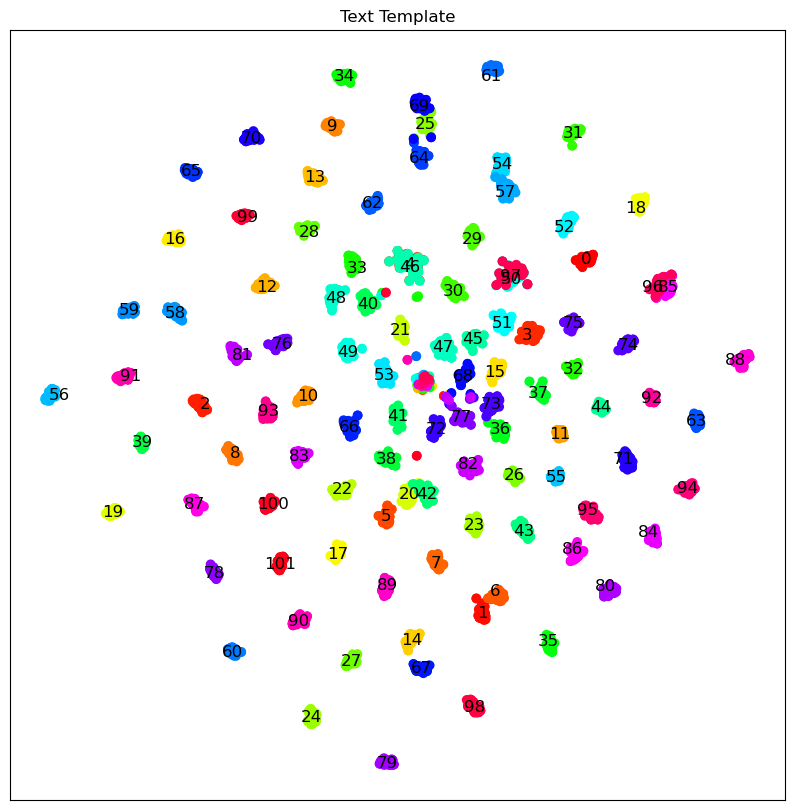

Rank 1: (4)english marigold - (46)marigold, similarity: 0.978515625
Rank 2: (50)petunia - (97)mexican petunia, similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, similarity: 0.94677734375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, similarity: 0.8984375
Rank 6: (25)corn poppy - (69)tree poppy, similarity: 0.8955078125
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.89501953125
Rank 8: (14)yellow iris - (67)bearded iris, similarity: 0.88916015625
Rank 9: (5)tiger lily - (20)fire lily, similarity: 0.888671875
Rank 10: (20)fire lily - (42)sword lily, similarity: 0.8818359375


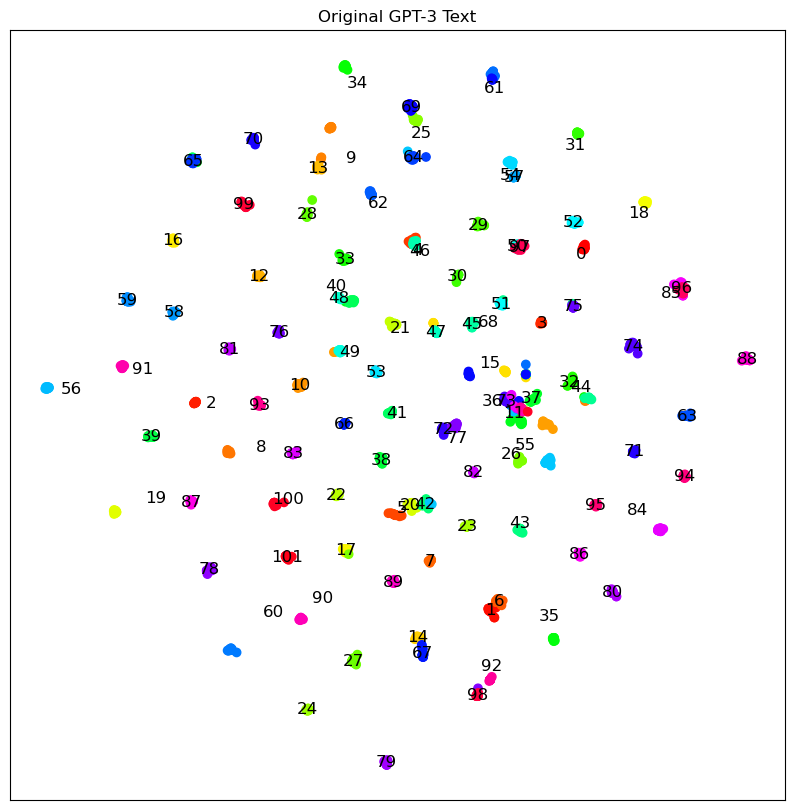

Rank 1: (4)english marigold - (46)marigold, similarity: 0.9775390625
Rank 2: (50)petunia - (97)mexican petunia, similarity: 0.95849609375
Rank 3: (85)tree mallow - (96)mallow, similarity: 0.9443359375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, similarity: 0.8955078125
Rank 6: (25)corn poppy - (69)tree poppy, similarity: 0.8935546875
Rank 7: (54)pelargonium - (57)geranium, similarity: 0.89013671875
Rank 8: (14)yellow iris - (67)bearded iris, similarity: 0.88916015625
Rank 9: (5)tiger lily - (20)fire lily, similarity: 0.8818359375
Rank 10: (20)fire lily - (42)sword lily, similarity: 0.88037109375


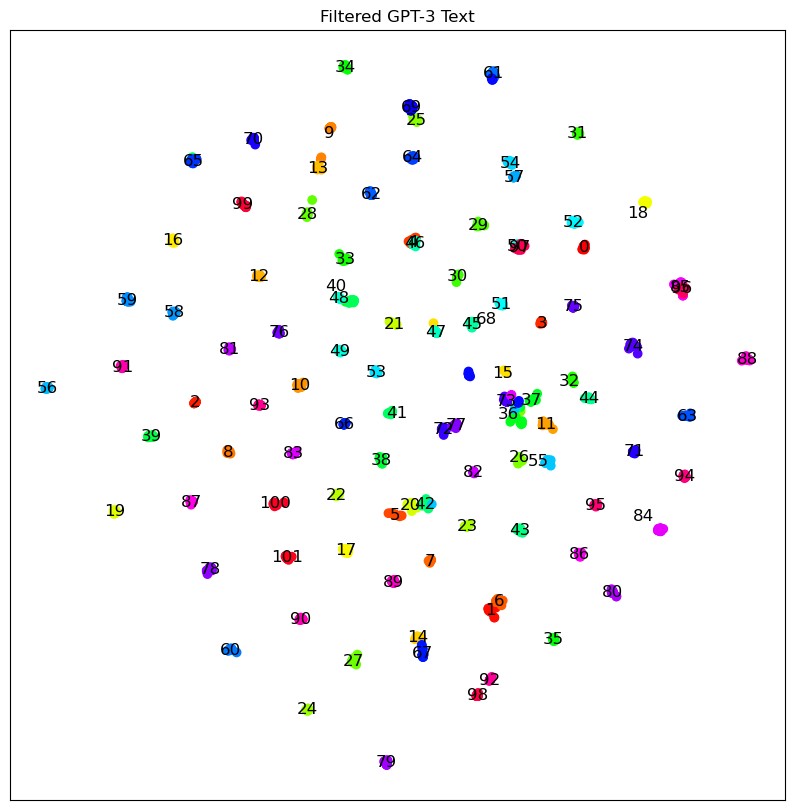

In [39]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')